# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
#data_dir = 'C:\\Users\\sevan\\data_dlnd\\face_gen'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

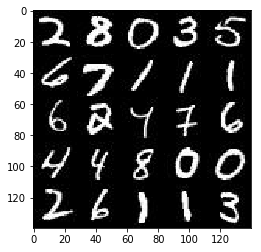

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

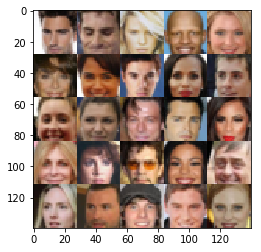

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def get_params():
    
    n_filters = 64
    alpha     = 0.1
    
    return n_filters, alpha
    

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    n_filters, alpha = get_params()
    
    with tf.variable_scope('discriminator', reuse=reuse):

        # convolutional layer, output = 16x16x64 
        p1 = tf.image.resize_image_with_crop_or_pad(images,32,32)
        x1 = tf.layers.conv2d(p1, n_filters, 5, strides=2, padding='same')
        a1 = tf.nn.leaky_relu(x1, alpha)

        # convolutional layer, output = 8x8x128 
        x2 = tf.layers.conv2d(a1, 2*n_filters, 5, strides=2, padding='same')
        n2 = tf.layers.batch_normalization(x2, training=True)
        a2 = tf.nn.leaky_relu(n2,alpha)
        
        # convolutional layer, output = 4x4x256
        x3 = tf.layers.conv2d(a2, 4*n_filters, 5, strides=2, padding='same')
        n3 = tf.layers.batch_normalization(x3, training=True)
        a3 = tf.nn.leaky_relu(n3, alpha)
    
        # convolutional layer, output = 4x4x512
        x4 = tf.layers.conv2d(a3, 8*n_filters, 5, strides=1, padding='same')
        n4 = tf.layers.batch_normalization(x4, training=True)
        a4 = tf.nn.leaky_relu(n4, alpha)

        # flatten, output = 8192  
        x5 = tf.reshape(a4, (-1, 4*4*(8*n_filters)))
        logits = tf.layers.dense(x5, 1)
    
        output = tf.sigmoid(logits)
    
        return output, logits   

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    n_filters, alpha = get_params()
    
    reuse = not is_train
    with tf.variable_scope('generator',reuse=reuse):

        # First fully connected layer
        x5 = tf.layers.dense(z, 4*4*(8*n_filters), activation=None)

        # Start the convolutional stack, output 4x4x512
        x4 = tf.reshape(x5, (-1, 4, 4, 8*n_filters))
        n4 = tf.layers.batch_normalization(x4, training=is_train)
        a4 = tf.nn.leaky_relu(n4, alpha)       

        # Convolutional transpose layer, output = 4x4x256
        x3 = tf.layers.conv2d_transpose(a4, 4*n_filters, 5, strides=1, padding='same')
        n3 = tf.layers.batch_normalization(x3, training=is_train)
        a3 = tf.nn.leaky_relu(n3, alpha)        
        
        # Convolutional transpose layer, output = 8x8x128
        x2 = tf.layers.conv2d_transpose(a3, 2*n_filters, 5, strides=2, padding='same')
        n2 = tf.layers.batch_normalization(x2, training=is_train)
        a2 = tf.nn.leaky_relu(n2, alpha)
        
        # Convolutional transpose layer, output = 16x16x64      
        x1 = tf.layers.conv2d_transpose(a2, n_filters, 5, strides=2, padding='same')
        n1 = tf.layers.batch_normalization(x1, training=is_train)
        a1 = tf.nn.leaky_relu(n1, alpha)
        
        # Convolutional transpose layer, output = 28x28x3
        logits = tf.layers.conv2d_transpose(a1, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_image_with_crop_or_pad(logits,28,28)
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    out_channel_dim = data_shape[3]
    n_images = 25
    print_every = 10
    plot_every = 200

    input_real, input_z, model_lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, model_lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            n_steps = np.ceil(data_shape[0]/batch_size).astype(np.int)
            for batch_images in get_batches(batch_size):
                
                # Sample random noise for G  
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Scale the batch_images by 2 since they were incorrectly normalized for this project.
                batch_images = 2*batch_images
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, model_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, model_lr: learning_rate})
            
                # print out the discriminator and generator training losses
                if step == 0 or (step + 1) % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, model_lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, model_lr: learning_rate})

                    losses.append((train_loss_d, train_loss_g))
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                            "Step {}/{}...".format(step+1, n_steps),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))

                if (step == 0) or (step+1) % plot_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)

                step += 1

            show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 1/1875... Discriminator Loss: 19.7647... Generator Loss: 13.2363


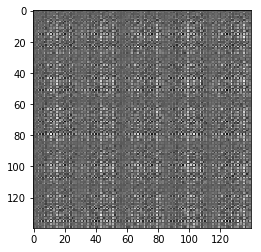

Epoch 1/2... Step 10/1875... Discriminator Loss: 7.2372... Generator Loss: 14.4135
Epoch 1/2... Step 20/1875... Discriminator Loss: 2.6656... Generator Loss: 5.3127
Epoch 1/2... Step 30/1875... Discriminator Loss: 0.4795... Generator Loss: 3.9340
Epoch 1/2... Step 40/1875... Discriminator Loss: 2.7899... Generator Loss: 5.3432
Epoch 1/2... Step 50/1875... Discriminator Loss: 1.4106... Generator Loss: 1.7972
Epoch 1/2... Step 60/1875... Discriminator Loss: 0.9351... Generator Loss: 0.8925
Epoch 1/2... Step 70/1875... Discriminator Loss: 1.1215... Generator Loss: 0.7484
Epoch 1/2... Step 80/1875... Discriminator Loss: 3.9880... Generator Loss: 9.7385
Epoch 1/2... Step 90/1875... Discriminator Loss: 1.6841... Generator Loss: 0.4635
Epoch 1/2... Step 100/1875... Discriminator Loss: 0.7866... Generator Loss: 1.5580
Epoch 1/2... Step 110/1875... Discriminator Loss: 1.5297... Generator Loss: 3.7031
Epoch 1/2... Step 120/1875... Discriminator Loss: 1.0292... Generator Loss: 0.8070
Epoch 1/2...

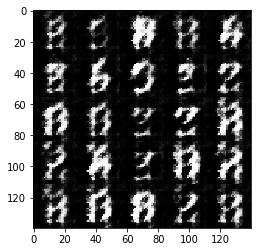

Epoch 1/2... Step 210/1875... Discriminator Loss: 1.4554... Generator Loss: 0.5690
Epoch 1/2... Step 220/1875... Discriminator Loss: 1.4682... Generator Loss: 0.5094
Epoch 1/2... Step 230/1875... Discriminator Loss: 1.2215... Generator Loss: 1.4168
Epoch 1/2... Step 240/1875... Discriminator Loss: 1.0009... Generator Loss: 1.6506
Epoch 1/2... Step 250/1875... Discriminator Loss: 2.5095... Generator Loss: 0.2955
Epoch 1/2... Step 260/1875... Discriminator Loss: 1.6778... Generator Loss: 3.8966
Epoch 1/2... Step 270/1875... Discriminator Loss: 1.2642... Generator Loss: 2.2390
Epoch 1/2... Step 280/1875... Discriminator Loss: 1.3698... Generator Loss: 0.6485
Epoch 1/2... Step 290/1875... Discriminator Loss: 2.3518... Generator Loss: 0.2422
Epoch 1/2... Step 300/1875... Discriminator Loss: 1.5847... Generator Loss: 0.3910
Epoch 1/2... Step 310/1875... Discriminator Loss: 1.8846... Generator Loss: 0.2840
Epoch 1/2... Step 320/1875... Discriminator Loss: 1.1698... Generator Loss: 2.4871
Epoc

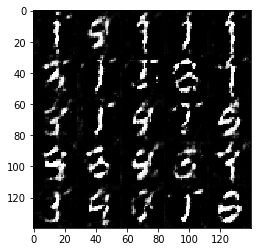

Epoch 1/2... Step 410/1875... Discriminator Loss: 1.2924... Generator Loss: 1.4457
Epoch 1/2... Step 420/1875... Discriminator Loss: 1.5306... Generator Loss: 0.4689
Epoch 1/2... Step 430/1875... Discriminator Loss: 1.6350... Generator Loss: 0.3976
Epoch 1/2... Step 440/1875... Discriminator Loss: 1.3546... Generator Loss: 1.9102
Epoch 1/2... Step 450/1875... Discriminator Loss: 1.2031... Generator Loss: 0.7854
Epoch 1/2... Step 460/1875... Discriminator Loss: 1.2905... Generator Loss: 0.6148
Epoch 1/2... Step 470/1875... Discriminator Loss: 1.7489... Generator Loss: 1.9553
Epoch 1/2... Step 480/1875... Discriminator Loss: 1.3248... Generator Loss: 0.9132
Epoch 1/2... Step 490/1875... Discriminator Loss: 1.5022... Generator Loss: 2.0190
Epoch 1/2... Step 500/1875... Discriminator Loss: 1.4138... Generator Loss: 2.1150
Epoch 1/2... Step 510/1875... Discriminator Loss: 1.5223... Generator Loss: 0.4567
Epoch 1/2... Step 520/1875... Discriminator Loss: 1.1481... Generator Loss: 1.2300
Epoc

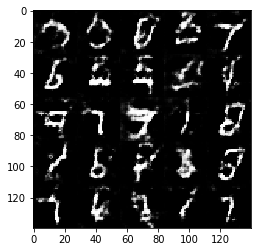

Epoch 1/2... Step 610/1875... Discriminator Loss: 1.6212... Generator Loss: 2.4135
Epoch 1/2... Step 620/1875... Discriminator Loss: 1.0953... Generator Loss: 0.9690
Epoch 1/2... Step 630/1875... Discriminator Loss: 0.9776... Generator Loss: 1.1325
Epoch 1/2... Step 640/1875... Discriminator Loss: 1.9264... Generator Loss: 0.2575
Epoch 1/2... Step 650/1875... Discriminator Loss: 1.6198... Generator Loss: 0.3664
Epoch 1/2... Step 660/1875... Discriminator Loss: 1.3621... Generator Loss: 0.6094
Epoch 1/2... Step 670/1875... Discriminator Loss: 1.6834... Generator Loss: 0.3472
Epoch 1/2... Step 680/1875... Discriminator Loss: 1.2479... Generator Loss: 1.6812
Epoch 1/2... Step 690/1875... Discriminator Loss: 1.3668... Generator Loss: 0.5940
Epoch 1/2... Step 700/1875... Discriminator Loss: 1.4611... Generator Loss: 0.5032
Epoch 1/2... Step 710/1875... Discriminator Loss: 1.1347... Generator Loss: 0.7918
Epoch 1/2... Step 720/1875... Discriminator Loss: 0.9192... Generator Loss: 1.0762
Epoc

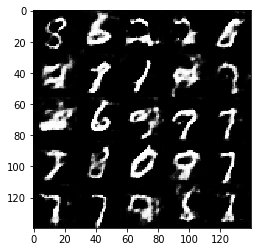

Epoch 1/2... Step 810/1875... Discriminator Loss: 1.1242... Generator Loss: 1.5133
Epoch 1/2... Step 820/1875... Discriminator Loss: 1.1607... Generator Loss: 0.6937
Epoch 1/2... Step 830/1875... Discriminator Loss: 1.5777... Generator Loss: 0.3955
Epoch 1/2... Step 840/1875... Discriminator Loss: 1.4761... Generator Loss: 0.6423
Epoch 1/2... Step 850/1875... Discriminator Loss: 1.3634... Generator Loss: 0.5326
Epoch 1/2... Step 860/1875... Discriminator Loss: 1.1559... Generator Loss: 1.1647
Epoch 1/2... Step 870/1875... Discriminator Loss: 1.2926... Generator Loss: 2.1516
Epoch 1/2... Step 880/1875... Discriminator Loss: 1.4579... Generator Loss: 0.5501
Epoch 1/2... Step 890/1875... Discriminator Loss: 1.2818... Generator Loss: 0.5745
Epoch 1/2... Step 900/1875... Discriminator Loss: 1.0402... Generator Loss: 1.0481
Epoch 1/2... Step 910/1875... Discriminator Loss: 1.8920... Generator Loss: 0.2835
Epoch 1/2... Step 920/1875... Discriminator Loss: 1.0546... Generator Loss: 1.2774
Epoc

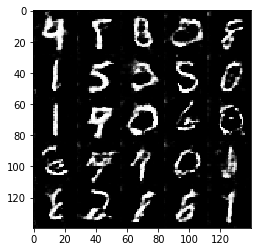

Epoch 1/2... Step 1010/1875... Discriminator Loss: 1.6346... Generator Loss: 0.3816
Epoch 1/2... Step 1020/1875... Discriminator Loss: 1.0868... Generator Loss: 1.1644
Epoch 1/2... Step 1030/1875... Discriminator Loss: 1.2158... Generator Loss: 2.5260
Epoch 1/2... Step 1040/1875... Discriminator Loss: 1.4273... Generator Loss: 0.5585
Epoch 1/2... Step 1050/1875... Discriminator Loss: 1.4068... Generator Loss: 0.5464
Epoch 1/2... Step 1060/1875... Discriminator Loss: 1.0946... Generator Loss: 1.7559
Epoch 1/2... Step 1070/1875... Discriminator Loss: 1.6941... Generator Loss: 0.3368
Epoch 1/2... Step 1080/1875... Discriminator Loss: 1.0586... Generator Loss: 1.1211
Epoch 1/2... Step 1090/1875... Discriminator Loss: 1.5158... Generator Loss: 0.4189
Epoch 1/2... Step 1100/1875... Discriminator Loss: 1.4952... Generator Loss: 2.3710
Epoch 1/2... Step 1110/1875... Discriminator Loss: 1.1868... Generator Loss: 1.7352
Epoch 1/2... Step 1120/1875... Discriminator Loss: 1.5934... Generator Loss:

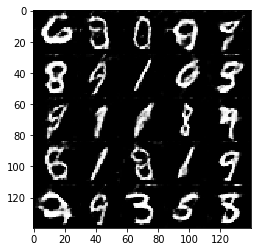

Epoch 1/2... Step 1210/1875... Discriminator Loss: 1.2216... Generator Loss: 0.6041
Epoch 1/2... Step 1220/1875... Discriminator Loss: 1.9113... Generator Loss: 0.2869
Epoch 1/2... Step 1230/1875... Discriminator Loss: 2.0255... Generator Loss: 0.2683
Epoch 1/2... Step 1240/1875... Discriminator Loss: 2.0437... Generator Loss: 0.2379
Epoch 1/2... Step 1250/1875... Discriminator Loss: 1.1777... Generator Loss: 1.2030
Epoch 1/2... Step 1260/1875... Discriminator Loss: 1.8751... Generator Loss: 0.2580
Epoch 1/2... Step 1270/1875... Discriminator Loss: 1.3576... Generator Loss: 0.5662
Epoch 1/2... Step 1280/1875... Discriminator Loss: 0.8220... Generator Loss: 1.4909
Epoch 1/2... Step 1290/1875... Discriminator Loss: 1.2869... Generator Loss: 1.5971
Epoch 1/2... Step 1300/1875... Discriminator Loss: 1.0147... Generator Loss: 1.8266
Epoch 1/2... Step 1310/1875... Discriminator Loss: 2.4062... Generator Loss: 0.1608
Epoch 1/2... Step 1320/1875... Discriminator Loss: 1.2742... Generator Loss:

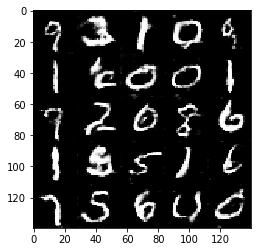

Epoch 1/2... Step 1410/1875... Discriminator Loss: 1.0912... Generator Loss: 0.9847
Epoch 1/2... Step 1420/1875... Discriminator Loss: 1.1753... Generator Loss: 0.9895
Epoch 1/2... Step 1430/1875... Discriminator Loss: 1.1528... Generator Loss: 0.9407
Epoch 1/2... Step 1440/1875... Discriminator Loss: 1.2473... Generator Loss: 1.0408
Epoch 1/2... Step 1450/1875... Discriminator Loss: 1.3639... Generator Loss: 0.9194
Epoch 1/2... Step 1460/1875... Discriminator Loss: 1.6389... Generator Loss: 0.3675
Epoch 1/2... Step 1470/1875... Discriminator Loss: 1.3301... Generator Loss: 0.5864
Epoch 1/2... Step 1480/1875... Discriminator Loss: 2.1802... Generator Loss: 0.1939
Epoch 1/2... Step 1490/1875... Discriminator Loss: 1.1027... Generator Loss: 0.8140
Epoch 1/2... Step 1500/1875... Discriminator Loss: 1.2124... Generator Loss: 0.8818
Epoch 1/2... Step 1510/1875... Discriminator Loss: 1.4683... Generator Loss: 0.5642
Epoch 1/2... Step 1520/1875... Discriminator Loss: 0.9778... Generator Loss:

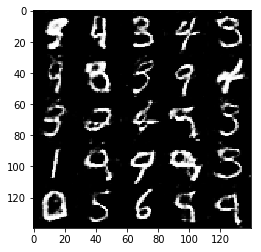

Epoch 1/2... Step 1610/1875... Discriminator Loss: 1.5581... Generator Loss: 0.4049
Epoch 1/2... Step 1620/1875... Discriminator Loss: 1.8753... Generator Loss: 0.3627
Epoch 1/2... Step 1630/1875... Discriminator Loss: 0.8629... Generator Loss: 1.3666
Epoch 1/2... Step 1640/1875... Discriminator Loss: 2.4040... Generator Loss: 0.1669
Epoch 1/2... Step 1650/1875... Discriminator Loss: 1.1671... Generator Loss: 0.6478
Epoch 1/2... Step 1660/1875... Discriminator Loss: 1.0396... Generator Loss: 1.7102
Epoch 1/2... Step 1670/1875... Discriminator Loss: 1.2123... Generator Loss: 1.2914
Epoch 1/2... Step 1680/1875... Discriminator Loss: 1.7969... Generator Loss: 0.3155
Epoch 1/2... Step 1690/1875... Discriminator Loss: 1.7877... Generator Loss: 0.3267
Epoch 1/2... Step 1700/1875... Discriminator Loss: 1.1011... Generator Loss: 1.5898
Epoch 1/2... Step 1710/1875... Discriminator Loss: 2.4898... Generator Loss: 3.8879
Epoch 1/2... Step 1720/1875... Discriminator Loss: 1.1718... Generator Loss:

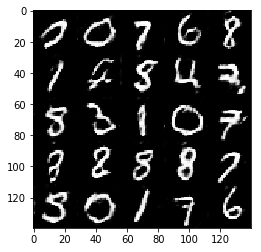

Epoch 1/2... Step 1810/1875... Discriminator Loss: 0.8576... Generator Loss: 1.6371
Epoch 1/2... Step 1820/1875... Discriminator Loss: 2.8576... Generator Loss: 0.1215
Epoch 1/2... Step 1830/1875... Discriminator Loss: 1.5143... Generator Loss: 0.4983
Epoch 1/2... Step 1840/1875... Discriminator Loss: 1.3565... Generator Loss: 2.1311
Epoch 1/2... Step 1850/1875... Discriminator Loss: 1.0972... Generator Loss: 0.8551
Epoch 1/2... Step 1860/1875... Discriminator Loss: 1.2122... Generator Loss: 0.6960
Epoch 1/2... Step 1870/1875... Discriminator Loss: 0.9525... Generator Loss: 1.4102


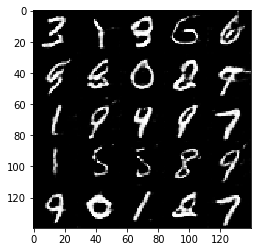

Epoch 2/2... Step 1/1875... Discriminator Loss: 1.4037... Generator Loss: 2.0283


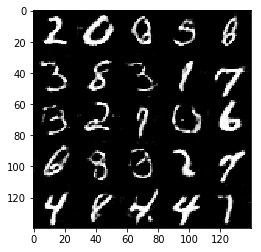

Epoch 2/2... Step 10/1875... Discriminator Loss: 1.1164... Generator Loss: 1.6797
Epoch 2/2... Step 20/1875... Discriminator Loss: 0.9581... Generator Loss: 1.0197
Epoch 2/2... Step 30/1875... Discriminator Loss: 1.1896... Generator Loss: 0.7223
Epoch 2/2... Step 40/1875... Discriminator Loss: 1.4426... Generator Loss: 0.5083
Epoch 2/2... Step 50/1875... Discriminator Loss: 1.1210... Generator Loss: 0.7669
Epoch 2/2... Step 60/1875... Discriminator Loss: 2.2745... Generator Loss: 0.1945
Epoch 2/2... Step 70/1875... Discriminator Loss: 1.6914... Generator Loss: 0.3988
Epoch 2/2... Step 80/1875... Discriminator Loss: 0.9235... Generator Loss: 1.1353
Epoch 2/2... Step 90/1875... Discriminator Loss: 1.3378... Generator Loss: 0.6346
Epoch 2/2... Step 100/1875... Discriminator Loss: 1.2748... Generator Loss: 0.6039
Epoch 2/2... Step 110/1875... Discriminator Loss: 1.4911... Generator Loss: 0.4833
Epoch 2/2... Step 120/1875... Discriminator Loss: 0.8833... Generator Loss: 1.4953
Epoch 2/2... 

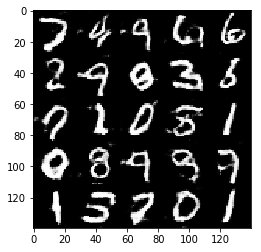

Epoch 2/2... Step 210/1875... Discriminator Loss: 1.4671... Generator Loss: 0.4712
Epoch 2/2... Step 220/1875... Discriminator Loss: 1.5630... Generator Loss: 0.4401
Epoch 2/2... Step 230/1875... Discriminator Loss: 1.2849... Generator Loss: 0.6418
Epoch 2/2... Step 240/1875... Discriminator Loss: 2.0630... Generator Loss: 2.7191
Epoch 2/2... Step 250/1875... Discriminator Loss: 1.9921... Generator Loss: 0.2507
Epoch 2/2... Step 260/1875... Discriminator Loss: 2.5252... Generator Loss: 0.1545
Epoch 2/2... Step 270/1875... Discriminator Loss: 1.4953... Generator Loss: 0.4767
Epoch 2/2... Step 280/1875... Discriminator Loss: 1.0703... Generator Loss: 0.8421
Epoch 2/2... Step 290/1875... Discriminator Loss: 1.3670... Generator Loss: 0.5572
Epoch 2/2... Step 300/1875... Discriminator Loss: 1.2598... Generator Loss: 2.4986
Epoch 2/2... Step 310/1875... Discriminator Loss: 1.2689... Generator Loss: 1.8360
Epoch 2/2... Step 320/1875... Discriminator Loss: 0.9560... Generator Loss: 0.9700
Epoc

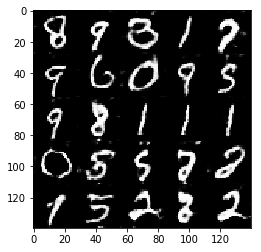

Epoch 2/2... Step 410/1875... Discriminator Loss: 1.9896... Generator Loss: 3.2391
Epoch 2/2... Step 420/1875... Discriminator Loss: 1.0355... Generator Loss: 1.1546
Epoch 2/2... Step 430/1875... Discriminator Loss: 1.3006... Generator Loss: 0.5990
Epoch 2/2... Step 440/1875... Discriminator Loss: 0.9490... Generator Loss: 1.1444
Epoch 2/2... Step 450/1875... Discriminator Loss: 2.3078... Generator Loss: 3.8063
Epoch 2/2... Step 460/1875... Discriminator Loss: 1.1618... Generator Loss: 0.6830
Epoch 2/2... Step 470/1875... Discriminator Loss: 2.3222... Generator Loss: 0.2606
Epoch 2/2... Step 480/1875... Discriminator Loss: 1.4266... Generator Loss: 0.5218
Epoch 2/2... Step 490/1875... Discriminator Loss: 0.8255... Generator Loss: 1.5833
Epoch 2/2... Step 500/1875... Discriminator Loss: 0.8862... Generator Loss: 2.0677
Epoch 2/2... Step 510/1875... Discriminator Loss: 0.9510... Generator Loss: 1.0751
Epoch 2/2... Step 520/1875... Discriminator Loss: 0.8358... Generator Loss: 1.2282
Epoc

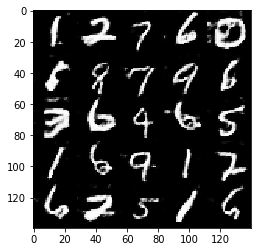

Epoch 2/2... Step 610/1875... Discriminator Loss: 1.2859... Generator Loss: 0.5269
Epoch 2/2... Step 620/1875... Discriminator Loss: 2.2228... Generator Loss: 0.1977
Epoch 2/2... Step 630/1875... Discriminator Loss: 1.6511... Generator Loss: 0.3724
Epoch 2/2... Step 640/1875... Discriminator Loss: 1.3717... Generator Loss: 0.5589
Epoch 2/2... Step 650/1875... Discriminator Loss: 1.3855... Generator Loss: 0.5041
Epoch 2/2... Step 660/1875... Discriminator Loss: 1.1667... Generator Loss: 2.7158
Epoch 2/2... Step 670/1875... Discriminator Loss: 0.9665... Generator Loss: 1.1881
Epoch 2/2... Step 680/1875... Discriminator Loss: 1.0329... Generator Loss: 0.8435
Epoch 2/2... Step 690/1875... Discriminator Loss: 0.9183... Generator Loss: 1.6679
Epoch 2/2... Step 700/1875... Discriminator Loss: 1.7429... Generator Loss: 0.4194
Epoch 2/2... Step 710/1875... Discriminator Loss: 0.9783... Generator Loss: 0.9135
Epoch 2/2... Step 720/1875... Discriminator Loss: 1.0316... Generator Loss: 0.9136
Epoc

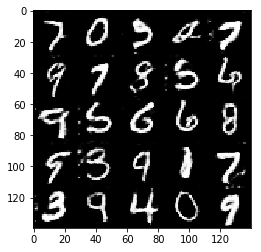

Epoch 2/2... Step 810/1875... Discriminator Loss: 2.8443... Generator Loss: 0.1179
Epoch 2/2... Step 820/1875... Discriminator Loss: 0.8034... Generator Loss: 1.6778
Epoch 2/2... Step 830/1875... Discriminator Loss: 1.5320... Generator Loss: 0.4240
Epoch 2/2... Step 840/1875... Discriminator Loss: 1.1924... Generator Loss: 0.7752
Epoch 2/2... Step 850/1875... Discriminator Loss: 2.3887... Generator Loss: 0.2322
Epoch 2/2... Step 860/1875... Discriminator Loss: 0.9347... Generator Loss: 1.4480
Epoch 2/2... Step 870/1875... Discriminator Loss: 1.7384... Generator Loss: 0.3300
Epoch 2/2... Step 880/1875... Discriminator Loss: 2.7486... Generator Loss: 0.1319
Epoch 2/2... Step 890/1875... Discriminator Loss: 1.8899... Generator Loss: 0.4397
Epoch 2/2... Step 900/1875... Discriminator Loss: 1.9964... Generator Loss: 0.2539
Epoch 2/2... Step 910/1875... Discriminator Loss: 2.0452... Generator Loss: 0.3102
Epoch 2/2... Step 920/1875... Discriminator Loss: 1.0045... Generator Loss: 0.8489
Epoc

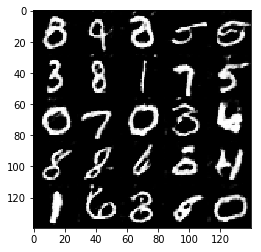

Epoch 2/2... Step 1010/1875... Discriminator Loss: 1.4890... Generator Loss: 2.7840
Epoch 2/2... Step 1020/1875... Discriminator Loss: 1.0659... Generator Loss: 1.0230
Epoch 2/2... Step 1030/1875... Discriminator Loss: 0.7076... Generator Loss: 1.6392
Epoch 2/2... Step 1040/1875... Discriminator Loss: 2.8087... Generator Loss: 0.1400
Epoch 2/2... Step 1050/1875... Discriminator Loss: 1.0169... Generator Loss: 0.8120
Epoch 2/2... Step 1060/1875... Discriminator Loss: 1.1399... Generator Loss: 1.7922
Epoch 2/2... Step 1070/1875... Discriminator Loss: 2.1560... Generator Loss: 0.2553
Epoch 2/2... Step 1080/1875... Discriminator Loss: 2.2783... Generator Loss: 0.2505
Epoch 2/2... Step 1090/1875... Discriminator Loss: 2.8100... Generator Loss: 0.1268
Epoch 2/2... Step 1100/1875... Discriminator Loss: 0.9249... Generator Loss: 1.0398
Epoch 2/2... Step 1110/1875... Discriminator Loss: 0.7466... Generator Loss: 2.4837
Epoch 2/2... Step 1120/1875... Discriminator Loss: 2.7529... Generator Loss:

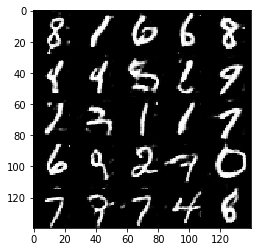

Epoch 2/2... Step 1210/1875... Discriminator Loss: 1.2202... Generator Loss: 0.6531
Epoch 2/2... Step 1220/1875... Discriminator Loss: 0.6714... Generator Loss: 2.8259
Epoch 2/2... Step 1230/1875... Discriminator Loss: 0.6955... Generator Loss: 1.9090
Epoch 2/2... Step 1240/1875... Discriminator Loss: 1.1146... Generator Loss: 0.9360
Epoch 2/2... Step 1250/1875... Discriminator Loss: 1.6082... Generator Loss: 1.1417
Epoch 2/2... Step 1260/1875... Discriminator Loss: 2.5497... Generator Loss: 0.1650
Epoch 2/2... Step 1270/1875... Discriminator Loss: 0.9341... Generator Loss: 1.1137
Epoch 2/2... Step 1280/1875... Discriminator Loss: 0.6859... Generator Loss: 1.6534
Epoch 2/2... Step 1290/1875... Discriminator Loss: 1.8494... Generator Loss: 0.3382
Epoch 2/2... Step 1300/1875... Discriminator Loss: 0.9267... Generator Loss: 2.6166
Epoch 2/2... Step 1310/1875... Discriminator Loss: 2.6224... Generator Loss: 0.1850
Epoch 2/2... Step 1320/1875... Discriminator Loss: 0.9907... Generator Loss:

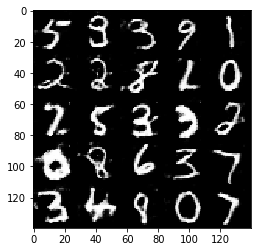

Epoch 2/2... Step 1410/1875... Discriminator Loss: 2.4438... Generator Loss: 0.1800
Epoch 2/2... Step 1420/1875... Discriminator Loss: 0.9365... Generator Loss: 1.5773
Epoch 2/2... Step 1430/1875... Discriminator Loss: 1.0988... Generator Loss: 1.0855
Epoch 2/2... Step 1440/1875... Discriminator Loss: 1.6669... Generator Loss: 2.8965
Epoch 2/2... Step 1450/1875... Discriminator Loss: 1.5729... Generator Loss: 0.4395
Epoch 2/2... Step 1460/1875... Discriminator Loss: 0.7018... Generator Loss: 1.6493
Epoch 2/2... Step 1470/1875... Discriminator Loss: 0.9768... Generator Loss: 1.4622
Epoch 2/2... Step 1480/1875... Discriminator Loss: 1.9311... Generator Loss: 0.2851
Epoch 2/2... Step 1490/1875... Discriminator Loss: 0.7467... Generator Loss: 2.1878
Epoch 2/2... Step 1500/1875... Discriminator Loss: 1.1028... Generator Loss: 0.7146
Epoch 2/2... Step 1510/1875... Discriminator Loss: 3.5215... Generator Loss: 0.0826
Epoch 2/2... Step 1520/1875... Discriminator Loss: 1.5170... Generator Loss:

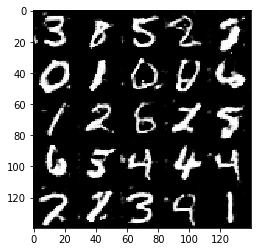

Epoch 2/2... Step 1610/1875... Discriminator Loss: 2.9983... Generator Loss: 4.6039
Epoch 2/2... Step 1620/1875... Discriminator Loss: 0.7874... Generator Loss: 1.2571
Epoch 2/2... Step 1630/1875... Discriminator Loss: 1.3925... Generator Loss: 0.5222
Epoch 2/2... Step 1640/1875... Discriminator Loss: 1.1481... Generator Loss: 1.7776
Epoch 2/2... Step 1650/1875... Discriminator Loss: 3.8798... Generator Loss: 0.0554
Epoch 2/2... Step 1660/1875... Discriminator Loss: 0.7437... Generator Loss: 1.2970
Epoch 2/2... Step 1670/1875... Discriminator Loss: 1.2286... Generator Loss: 0.8198
Epoch 2/2... Step 1680/1875... Discriminator Loss: 1.1149... Generator Loss: 0.7777
Epoch 2/2... Step 1690/1875... Discriminator Loss: 1.7551... Generator Loss: 0.3926
Epoch 2/2... Step 1700/1875... Discriminator Loss: 1.5702... Generator Loss: 0.4955
Epoch 2/2... Step 1710/1875... Discriminator Loss: 0.8136... Generator Loss: 1.7230
Epoch 2/2... Step 1720/1875... Discriminator Loss: 1.0891... Generator Loss:

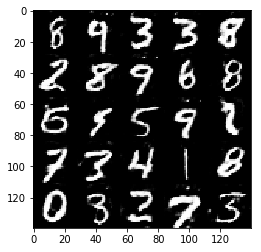

Epoch 2/2... Step 1810/1875... Discriminator Loss: 0.7974... Generator Loss: 1.2649
Epoch 2/2... Step 1820/1875... Discriminator Loss: 1.9477... Generator Loss: 0.2904
Epoch 2/2... Step 1830/1875... Discriminator Loss: 1.2923... Generator Loss: 0.6274
Epoch 2/2... Step 1840/1875... Discriminator Loss: 1.8879... Generator Loss: 0.2813
Epoch 2/2... Step 1850/1875... Discriminator Loss: 0.8529... Generator Loss: 1.6977
Epoch 2/2... Step 1860/1875... Discriminator Loss: 0.5968... Generator Loss: 2.1217
Epoch 2/2... Step 1870/1875... Discriminator Loss: 1.5294... Generator Loss: 0.4330


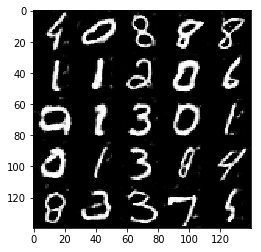

In [28]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.35

losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

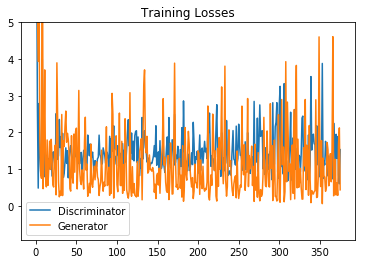

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.ylim(ymax=5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 1/6332... Discriminator Loss: 1.2095... Generator Loss: 0.9600


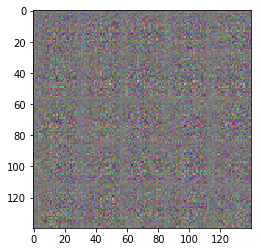

Epoch 1/1... Step 10/6332... Discriminator Loss: 5.9103... Generator Loss: 18.8837
Epoch 1/1... Step 20/6332... Discriminator Loss: 0.6278... Generator Loss: 7.3158
Epoch 1/1... Step 30/6332... Discriminator Loss: 0.7614... Generator Loss: 2.1725
Epoch 1/1... Step 40/6332... Discriminator Loss: 0.4729... Generator Loss: 8.9745
Epoch 1/1... Step 50/6332... Discriminator Loss: 2.5341... Generator Loss: 0.4957
Epoch 1/1... Step 60/6332... Discriminator Loss: 1.2106... Generator Loss: 1.2559
Epoch 1/1... Step 70/6332... Discriminator Loss: 0.8187... Generator Loss: 2.5502
Epoch 1/1... Step 80/6332... Discriminator Loss: 1.0812... Generator Loss: 4.6181
Epoch 1/1... Step 90/6332... Discriminator Loss: 0.7607... Generator Loss: 3.7856
Epoch 1/1... Step 100/6332... Discriminator Loss: 1.5786... Generator Loss: 0.4751
Epoch 1/1... Step 110/6332... Discriminator Loss: 1.8445... Generator Loss: 0.3554
Epoch 1/1... Step 120/6332... Discriminator Loss: 0.6752... Generator Loss: 1.8095
Epoch 1/1...

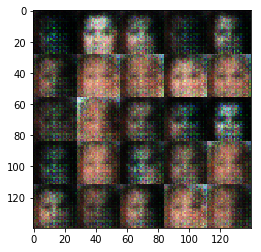

Epoch 1/1... Step 210/6332... Discriminator Loss: 1.4545... Generator Loss: 0.6638
Epoch 1/1... Step 220/6332... Discriminator Loss: 1.2016... Generator Loss: 0.8349
Epoch 1/1... Step 230/6332... Discriminator Loss: 1.3362... Generator Loss: 0.7509
Epoch 1/1... Step 240/6332... Discriminator Loss: 1.5150... Generator Loss: 2.4717
Epoch 1/1... Step 250/6332... Discriminator Loss: 0.8445... Generator Loss: 1.8241
Epoch 1/1... Step 260/6332... Discriminator Loss: 0.9410... Generator Loss: 1.2971
Epoch 1/1... Step 270/6332... Discriminator Loss: 1.4440... Generator Loss: 3.0242
Epoch 1/1... Step 280/6332... Discriminator Loss: 1.0654... Generator Loss: 1.3622
Epoch 1/1... Step 290/6332... Discriminator Loss: 1.0952... Generator Loss: 2.0463
Epoch 1/1... Step 300/6332... Discriminator Loss: 1.3809... Generator Loss: 0.6015
Epoch 1/1... Step 310/6332... Discriminator Loss: 1.0395... Generator Loss: 1.7979
Epoch 1/1... Step 320/6332... Discriminator Loss: 1.3668... Generator Loss: 2.5603
Epoc

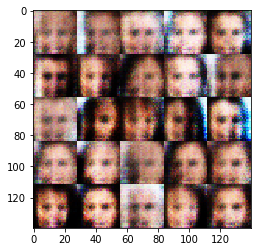

Epoch 1/1... Step 410/6332... Discriminator Loss: 1.3066... Generator Loss: 0.8721
Epoch 1/1... Step 420/6332... Discriminator Loss: 1.2030... Generator Loss: 1.3081
Epoch 1/1... Step 430/6332... Discriminator Loss: 1.0225... Generator Loss: 1.2579
Epoch 1/1... Step 440/6332... Discriminator Loss: 1.2425... Generator Loss: 0.6828
Epoch 1/1... Step 450/6332... Discriminator Loss: 2.0242... Generator Loss: 0.3144
Epoch 1/1... Step 460/6332... Discriminator Loss: 1.7419... Generator Loss: 3.4000
Epoch 1/1... Step 470/6332... Discriminator Loss: 1.6396... Generator Loss: 0.3610
Epoch 1/1... Step 480/6332... Discriminator Loss: 1.4256... Generator Loss: 0.5393
Epoch 1/1... Step 490/6332... Discriminator Loss: 0.9849... Generator Loss: 0.9731
Epoch 1/1... Step 500/6332... Discriminator Loss: 1.2620... Generator Loss: 0.6196
Epoch 1/1... Step 510/6332... Discriminator Loss: 0.9460... Generator Loss: 1.0178
Epoch 1/1... Step 520/6332... Discriminator Loss: 0.9731... Generator Loss: 1.3780
Epoc

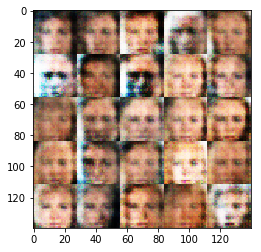

Epoch 1/1... Step 610/6332... Discriminator Loss: 1.0951... Generator Loss: 1.5269
Epoch 1/1... Step 620/6332... Discriminator Loss: 1.3255... Generator Loss: 2.5285
Epoch 1/1... Step 630/6332... Discriminator Loss: 1.0950... Generator Loss: 1.2717
Epoch 1/1... Step 640/6332... Discriminator Loss: 1.1599... Generator Loss: 1.9121
Epoch 1/1... Step 650/6332... Discriminator Loss: 1.1675... Generator Loss: 1.3778
Epoch 1/1... Step 660/6332... Discriminator Loss: 0.9653... Generator Loss: 1.2307
Epoch 1/1... Step 670/6332... Discriminator Loss: 1.2221... Generator Loss: 2.6142
Epoch 1/1... Step 680/6332... Discriminator Loss: 1.3634... Generator Loss: 0.6351
Epoch 1/1... Step 690/6332... Discriminator Loss: 1.0647... Generator Loss: 0.8911
Epoch 1/1... Step 700/6332... Discriminator Loss: 0.9833... Generator Loss: 0.9948
Epoch 1/1... Step 710/6332... Discriminator Loss: 2.0462... Generator Loss: 0.2523
Epoch 1/1... Step 720/6332... Discriminator Loss: 1.1796... Generator Loss: 0.7151
Epoc

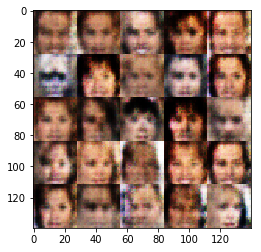

Epoch 1/1... Step 810/6332... Discriminator Loss: 1.3047... Generator Loss: 0.6316
Epoch 1/1... Step 820/6332... Discriminator Loss: 1.0910... Generator Loss: 0.7750
Epoch 1/1... Step 830/6332... Discriminator Loss: 1.1628... Generator Loss: 0.6441
Epoch 1/1... Step 840/6332... Discriminator Loss: 2.6293... Generator Loss: 3.8369
Epoch 1/1... Step 850/6332... Discriminator Loss: 1.0263... Generator Loss: 1.3304
Epoch 1/1... Step 860/6332... Discriminator Loss: 1.0398... Generator Loss: 1.8669
Epoch 1/1... Step 870/6332... Discriminator Loss: 0.9821... Generator Loss: 1.9142
Epoch 1/1... Step 880/6332... Discriminator Loss: 1.4180... Generator Loss: 0.5769
Epoch 1/1... Step 890/6332... Discriminator Loss: 1.5714... Generator Loss: 0.4930
Epoch 1/1... Step 900/6332... Discriminator Loss: 1.7728... Generator Loss: 0.3438
Epoch 1/1... Step 910/6332... Discriminator Loss: 1.3069... Generator Loss: 2.1753
Epoch 1/1... Step 920/6332... Discriminator Loss: 1.5989... Generator Loss: 0.3976
Epoc

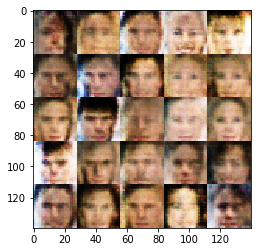

Epoch 1/1... Step 1010/6332... Discriminator Loss: 0.9919... Generator Loss: 1.9683
Epoch 1/1... Step 1020/6332... Discriminator Loss: 1.4372... Generator Loss: 0.5086
Epoch 1/1... Step 1030/6332... Discriminator Loss: 1.9606... Generator Loss: 0.2907
Epoch 1/1... Step 1040/6332... Discriminator Loss: 1.1881... Generator Loss: 1.6038
Epoch 1/1... Step 1050/6332... Discriminator Loss: 1.0705... Generator Loss: 0.9857
Epoch 1/1... Step 1060/6332... Discriminator Loss: 1.1766... Generator Loss: 1.0585
Epoch 1/1... Step 1070/6332... Discriminator Loss: 1.0856... Generator Loss: 0.8522
Epoch 1/1... Step 1080/6332... Discriminator Loss: 0.8581... Generator Loss: 1.1138
Epoch 1/1... Step 1090/6332... Discriminator Loss: 1.1113... Generator Loss: 0.7499
Epoch 1/1... Step 1100/6332... Discriminator Loss: 1.6236... Generator Loss: 0.4624
Epoch 1/1... Step 1110/6332... Discriminator Loss: 1.4228... Generator Loss: 0.5866
Epoch 1/1... Step 1120/6332... Discriminator Loss: 1.2075... Generator Loss:

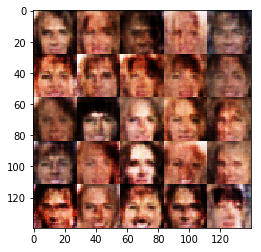

Epoch 1/1... Step 1210/6332... Discriminator Loss: 1.0006... Generator Loss: 0.9179
Epoch 1/1... Step 1220/6332... Discriminator Loss: 2.1398... Generator Loss: 0.2039
Epoch 1/1... Step 1230/6332... Discriminator Loss: 1.3192... Generator Loss: 0.5480
Epoch 1/1... Step 1240/6332... Discriminator Loss: 0.9255... Generator Loss: 1.7598
Epoch 1/1... Step 1250/6332... Discriminator Loss: 1.0082... Generator Loss: 0.8359
Epoch 1/1... Step 1260/6332... Discriminator Loss: 1.0004... Generator Loss: 1.1960
Epoch 1/1... Step 1270/6332... Discriminator Loss: 1.0602... Generator Loss: 0.8293
Epoch 1/1... Step 1280/6332... Discriminator Loss: 1.5553... Generator Loss: 0.4120
Epoch 1/1... Step 1290/6332... Discriminator Loss: 0.9355... Generator Loss: 1.2700
Epoch 1/1... Step 1300/6332... Discriminator Loss: 1.1154... Generator Loss: 1.2220
Epoch 1/1... Step 1310/6332... Discriminator Loss: 1.1749... Generator Loss: 0.7287
Epoch 1/1... Step 1320/6332... Discriminator Loss: 1.1693... Generator Loss:

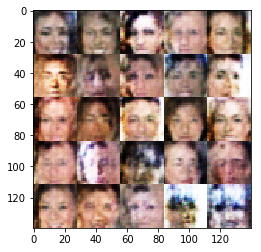

Epoch 1/1... Step 1410/6332... Discriminator Loss: 1.1876... Generator Loss: 0.6755
Epoch 1/1... Step 1420/6332... Discriminator Loss: 0.8574... Generator Loss: 1.2204
Epoch 1/1... Step 1430/6332... Discriminator Loss: 1.5871... Generator Loss: 0.3883
Epoch 1/1... Step 1440/6332... Discriminator Loss: 1.3409... Generator Loss: 0.5781
Epoch 1/1... Step 1450/6332... Discriminator Loss: 1.1776... Generator Loss: 0.8378
Epoch 1/1... Step 1460/6332... Discriminator Loss: 1.7975... Generator Loss: 0.2864
Epoch 1/1... Step 1470/6332... Discriminator Loss: 1.2026... Generator Loss: 0.7765
Epoch 1/1... Step 1480/6332... Discriminator Loss: 1.1552... Generator Loss: 2.0363
Epoch 1/1... Step 1490/6332... Discriminator Loss: 2.2206... Generator Loss: 0.1941
Epoch 1/1... Step 1500/6332... Discriminator Loss: 1.3440... Generator Loss: 0.5708
Epoch 1/1... Step 1510/6332... Discriminator Loss: 1.0468... Generator Loss: 0.8752
Epoch 1/1... Step 1520/6332... Discriminator Loss: 1.3345... Generator Loss:

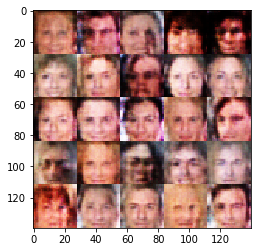

Epoch 1/1... Step 1610/6332... Discriminator Loss: 0.9977... Generator Loss: 1.0250
Epoch 1/1... Step 1620/6332... Discriminator Loss: 1.0943... Generator Loss: 1.0593
Epoch 1/1... Step 1630/6332... Discriminator Loss: 0.9233... Generator Loss: 1.2260
Epoch 1/1... Step 1640/6332... Discriminator Loss: 1.3359... Generator Loss: 0.5597
Epoch 1/1... Step 1650/6332... Discriminator Loss: 1.0530... Generator Loss: 0.8207
Epoch 1/1... Step 1660/6332... Discriminator Loss: 1.1006... Generator Loss: 0.8343
Epoch 1/1... Step 1670/6332... Discriminator Loss: 1.2492... Generator Loss: 0.5543
Epoch 1/1... Step 1680/6332... Discriminator Loss: 1.0031... Generator Loss: 1.1870
Epoch 1/1... Step 1690/6332... Discriminator Loss: 1.5913... Generator Loss: 0.3886
Epoch 1/1... Step 1700/6332... Discriminator Loss: 1.7607... Generator Loss: 0.3048
Epoch 1/1... Step 1710/6332... Discriminator Loss: 0.9468... Generator Loss: 1.6104
Epoch 1/1... Step 1720/6332... Discriminator Loss: 1.3014... Generator Loss:

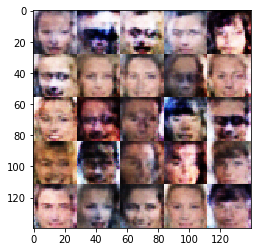

Epoch 1/1... Step 1810/6332... Discriminator Loss: 1.6802... Generator Loss: 0.3467
Epoch 1/1... Step 1820/6332... Discriminator Loss: 1.1191... Generator Loss: 0.8917
Epoch 1/1... Step 1830/6332... Discriminator Loss: 1.2400... Generator Loss: 0.7425
Epoch 1/1... Step 1840/6332... Discriminator Loss: 1.1252... Generator Loss: 0.8189
Epoch 1/1... Step 1850/6332... Discriminator Loss: 1.5836... Generator Loss: 0.3973
Epoch 1/1... Step 1860/6332... Discriminator Loss: 1.5271... Generator Loss: 0.4457
Epoch 1/1... Step 1870/6332... Discriminator Loss: 1.2680... Generator Loss: 0.5722
Epoch 1/1... Step 1880/6332... Discriminator Loss: 1.1380... Generator Loss: 0.7354
Epoch 1/1... Step 1890/6332... Discriminator Loss: 1.0688... Generator Loss: 0.8600
Epoch 1/1... Step 1900/6332... Discriminator Loss: 1.4852... Generator Loss: 0.4429
Epoch 1/1... Step 1910/6332... Discriminator Loss: 1.5236... Generator Loss: 0.4306
Epoch 1/1... Step 1920/6332... Discriminator Loss: 1.3527... Generator Loss:

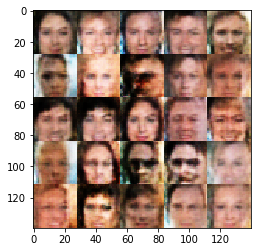

Epoch 1/1... Step 2010/6332... Discriminator Loss: 1.1489... Generator Loss: 1.0721
Epoch 1/1... Step 2020/6332... Discriminator Loss: 1.1090... Generator Loss: 0.7302
Epoch 1/1... Step 2030/6332... Discriminator Loss: 1.0824... Generator Loss: 1.1363
Epoch 1/1... Step 2040/6332... Discriminator Loss: 1.1189... Generator Loss: 0.8867
Epoch 1/1... Step 2050/6332... Discriminator Loss: 1.4776... Generator Loss: 0.4558
Epoch 1/1... Step 2060/6332... Discriminator Loss: 1.0808... Generator Loss: 1.2103
Epoch 1/1... Step 2070/6332... Discriminator Loss: 1.0882... Generator Loss: 1.0141
Epoch 1/1... Step 2080/6332... Discriminator Loss: 1.2460... Generator Loss: 0.6374
Epoch 1/1... Step 2090/6332... Discriminator Loss: 1.6556... Generator Loss: 0.3599
Epoch 1/1... Step 2100/6332... Discriminator Loss: 0.9181... Generator Loss: 0.9826
Epoch 1/1... Step 2110/6332... Discriminator Loss: 1.0744... Generator Loss: 1.6395
Epoch 1/1... Step 2120/6332... Discriminator Loss: 1.1916... Generator Loss:

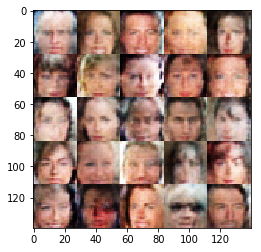

Epoch 1/1... Step 2210/6332... Discriminator Loss: 1.0124... Generator Loss: 1.1446
Epoch 1/1... Step 2220/6332... Discriminator Loss: 1.3260... Generator Loss: 0.5143
Epoch 1/1... Step 2230/6332... Discriminator Loss: 1.1293... Generator Loss: 0.7183
Epoch 1/1... Step 2240/6332... Discriminator Loss: 1.4533... Generator Loss: 0.4878
Epoch 1/1... Step 2250/6332... Discriminator Loss: 1.0886... Generator Loss: 0.8665
Epoch 1/1... Step 2260/6332... Discriminator Loss: 0.9736... Generator Loss: 1.0429
Epoch 1/1... Step 2270/6332... Discriminator Loss: 1.1864... Generator Loss: 0.7440
Epoch 1/1... Step 2280/6332... Discriminator Loss: 0.9798... Generator Loss: 1.1274
Epoch 1/1... Step 2290/6332... Discriminator Loss: 1.0879... Generator Loss: 0.7268
Epoch 1/1... Step 2300/6332... Discriminator Loss: 1.2148... Generator Loss: 0.6735
Epoch 1/1... Step 2310/6332... Discriminator Loss: 1.1653... Generator Loss: 0.7934
Epoch 1/1... Step 2320/6332... Discriminator Loss: 1.1535... Generator Loss:

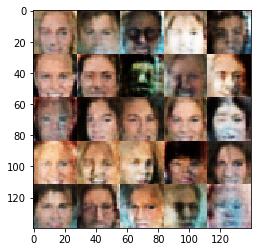

Epoch 1/1... Step 2410/6332... Discriminator Loss: 1.2099... Generator Loss: 0.6734
Epoch 1/1... Step 2420/6332... Discriminator Loss: 0.9264... Generator Loss: 1.6132
Epoch 1/1... Step 2430/6332... Discriminator Loss: 1.6179... Generator Loss: 2.7611
Epoch 1/1... Step 2440/6332... Discriminator Loss: 1.2858... Generator Loss: 0.5467
Epoch 1/1... Step 2450/6332... Discriminator Loss: 1.0618... Generator Loss: 0.8951
Epoch 1/1... Step 2460/6332... Discriminator Loss: 1.2453... Generator Loss: 0.5851
Epoch 1/1... Step 2470/6332... Discriminator Loss: 1.3459... Generator Loss: 0.6364
Epoch 1/1... Step 2480/6332... Discriminator Loss: 0.9497... Generator Loss: 1.7821
Epoch 1/1... Step 2490/6332... Discriminator Loss: 1.1858... Generator Loss: 1.1146
Epoch 1/1... Step 2500/6332... Discriminator Loss: 1.8565... Generator Loss: 0.2927
Epoch 1/1... Step 2510/6332... Discriminator Loss: 1.1224... Generator Loss: 1.2104
Epoch 1/1... Step 2520/6332... Discriminator Loss: 1.1577... Generator Loss:

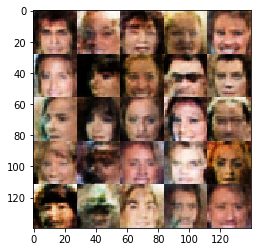

Epoch 1/1... Step 2610/6332... Discriminator Loss: 1.3074... Generator Loss: 0.7103
Epoch 1/1... Step 2620/6332... Discriminator Loss: 1.7581... Generator Loss: 0.3037
Epoch 1/1... Step 2630/6332... Discriminator Loss: 1.0391... Generator Loss: 1.0731
Epoch 1/1... Step 2640/6332... Discriminator Loss: 1.6482... Generator Loss: 0.3883
Epoch 1/1... Step 2650/6332... Discriminator Loss: 1.1649... Generator Loss: 1.1645
Epoch 1/1... Step 2660/6332... Discriminator Loss: 0.9816... Generator Loss: 1.4497
Epoch 1/1... Step 2670/6332... Discriminator Loss: 1.2015... Generator Loss: 2.5659
Epoch 1/1... Step 2680/6332... Discriminator Loss: 0.9807... Generator Loss: 1.0747
Epoch 1/1... Step 2690/6332... Discriminator Loss: 1.0294... Generator Loss: 0.9506
Epoch 1/1... Step 2700/6332... Discriminator Loss: 0.9879... Generator Loss: 1.5910
Epoch 1/1... Step 2710/6332... Discriminator Loss: 1.6989... Generator Loss: 0.3492
Epoch 1/1... Step 2720/6332... Discriminator Loss: 1.4426... Generator Loss:

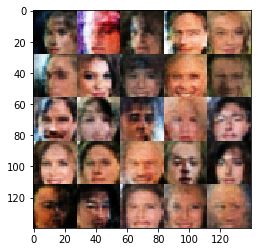

Epoch 1/1... Step 2810/6332... Discriminator Loss: 1.2205... Generator Loss: 0.6876
Epoch 1/1... Step 2820/6332... Discriminator Loss: 1.2110... Generator Loss: 0.5993
Epoch 1/1... Step 2830/6332... Discriminator Loss: 1.9441... Generator Loss: 0.2705
Epoch 1/1... Step 2840/6332... Discriminator Loss: 1.0572... Generator Loss: 1.0015
Epoch 1/1... Step 2850/6332... Discriminator Loss: 1.0670... Generator Loss: 1.9635
Epoch 1/1... Step 2860/6332... Discriminator Loss: 1.2660... Generator Loss: 0.8449
Epoch 1/1... Step 2870/6332... Discriminator Loss: 1.2689... Generator Loss: 0.5514
Epoch 1/1... Step 2880/6332... Discriminator Loss: 1.0007... Generator Loss: 1.1003
Epoch 1/1... Step 2890/6332... Discriminator Loss: 1.5507... Generator Loss: 0.4371
Epoch 1/1... Step 2900/6332... Discriminator Loss: 1.1333... Generator Loss: 1.0586
Epoch 1/1... Step 2910/6332... Discriminator Loss: 0.9926... Generator Loss: 1.0724
Epoch 1/1... Step 2920/6332... Discriminator Loss: 1.3598... Generator Loss:

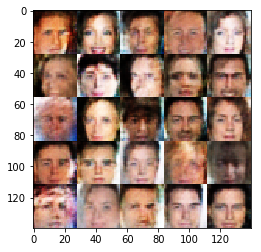

Epoch 1/1... Step 3010/6332... Discriminator Loss: 1.0182... Generator Loss: 0.8854
Epoch 1/1... Step 3020/6332... Discriminator Loss: 1.2707... Generator Loss: 0.5916
Epoch 1/1... Step 3030/6332... Discriminator Loss: 1.0985... Generator Loss: 2.1395
Epoch 1/1... Step 3040/6332... Discriminator Loss: 1.0826... Generator Loss: 1.9038
Epoch 1/1... Step 3050/6332... Discriminator Loss: 1.0355... Generator Loss: 1.1324
Epoch 1/1... Step 3060/6332... Discriminator Loss: 1.1454... Generator Loss: 0.8231
Epoch 1/1... Step 3070/6332... Discriminator Loss: 1.0630... Generator Loss: 0.7750
Epoch 1/1... Step 3080/6332... Discriminator Loss: 1.0005... Generator Loss: 1.2036
Epoch 1/1... Step 3090/6332... Discriminator Loss: 1.4910... Generator Loss: 0.4631
Epoch 1/1... Step 3100/6332... Discriminator Loss: 1.0528... Generator Loss: 0.9619
Epoch 1/1... Step 3110/6332... Discriminator Loss: 1.2563... Generator Loss: 0.7097
Epoch 1/1... Step 3120/6332... Discriminator Loss: 1.2657... Generator Loss:

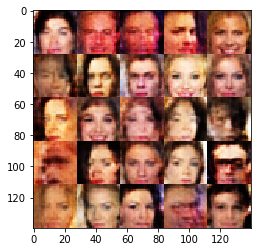

Epoch 1/1... Step 3210/6332... Discriminator Loss: 0.8731... Generator Loss: 1.2998
Epoch 1/1... Step 3220/6332... Discriminator Loss: 1.0369... Generator Loss: 0.9108
Epoch 1/1... Step 3230/6332... Discriminator Loss: 1.1662... Generator Loss: 0.6515
Epoch 1/1... Step 3240/6332... Discriminator Loss: 1.3745... Generator Loss: 0.5351
Epoch 1/1... Step 3250/6332... Discriminator Loss: 0.9115... Generator Loss: 1.0947
Epoch 1/1... Step 3260/6332... Discriminator Loss: 1.0976... Generator Loss: 0.8157
Epoch 1/1... Step 3270/6332... Discriminator Loss: 1.1850... Generator Loss: 0.6599
Epoch 1/1... Step 3280/6332... Discriminator Loss: 1.4448... Generator Loss: 0.4947
Epoch 1/1... Step 3290/6332... Discriminator Loss: 1.1436... Generator Loss: 0.7370
Epoch 1/1... Step 3300/6332... Discriminator Loss: 2.2280... Generator Loss: 0.2103
Epoch 1/1... Step 3310/6332... Discriminator Loss: 1.3774... Generator Loss: 0.4848
Epoch 1/1... Step 3320/6332... Discriminator Loss: 1.7296... Generator Loss:

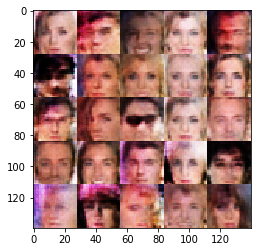

Epoch 1/1... Step 3410/6332... Discriminator Loss: 1.3269... Generator Loss: 0.5935
Epoch 1/1... Step 3420/6332... Discriminator Loss: 1.1372... Generator Loss: 0.8446
Epoch 1/1... Step 3430/6332... Discriminator Loss: 1.6532... Generator Loss: 0.3294
Epoch 1/1... Step 3440/6332... Discriminator Loss: 1.3272... Generator Loss: 0.5132
Epoch 1/1... Step 3450/6332... Discriminator Loss: 1.0464... Generator Loss: 1.0910
Epoch 1/1... Step 3460/6332... Discriminator Loss: 1.7351... Generator Loss: 0.3406
Epoch 1/1... Step 3470/6332... Discriminator Loss: 1.0996... Generator Loss: 0.7401
Epoch 1/1... Step 3480/6332... Discriminator Loss: 2.0338... Generator Loss: 0.2698
Epoch 1/1... Step 3490/6332... Discriminator Loss: 1.1980... Generator Loss: 0.8005
Epoch 1/1... Step 3500/6332... Discriminator Loss: 1.5481... Generator Loss: 0.4874
Epoch 1/1... Step 3510/6332... Discriminator Loss: 1.3988... Generator Loss: 0.5363
Epoch 1/1... Step 3520/6332... Discriminator Loss: 1.3811... Generator Loss:

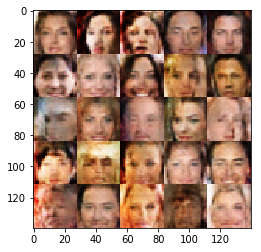

Epoch 1/1... Step 3610/6332... Discriminator Loss: 1.2159... Generator Loss: 0.7613
Epoch 1/1... Step 3620/6332... Discriminator Loss: 1.5628... Generator Loss: 0.4393
Epoch 1/1... Step 3630/6332... Discriminator Loss: 1.6002... Generator Loss: 0.3701
Epoch 1/1... Step 3640/6332... Discriminator Loss: 0.9538... Generator Loss: 0.9002
Epoch 1/1... Step 3650/6332... Discriminator Loss: 1.4361... Generator Loss: 0.5447
Epoch 1/1... Step 3660/6332... Discriminator Loss: 0.9466... Generator Loss: 1.2577
Epoch 1/1... Step 3670/6332... Discriminator Loss: 1.2896... Generator Loss: 0.5359
Epoch 1/1... Step 3680/6332... Discriminator Loss: 0.9758... Generator Loss: 1.1299
Epoch 1/1... Step 3690/6332... Discriminator Loss: 0.9504... Generator Loss: 1.3674
Epoch 1/1... Step 3700/6332... Discriminator Loss: 1.1923... Generator Loss: 0.7221
Epoch 1/1... Step 3710/6332... Discriminator Loss: 1.1559... Generator Loss: 0.8324
Epoch 1/1... Step 3720/6332... Discriminator Loss: 1.1273... Generator Loss:

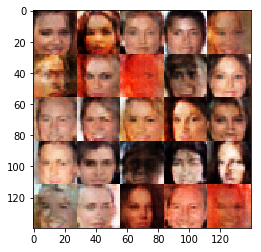

Epoch 1/1... Step 3810/6332... Discriminator Loss: 1.4259... Generator Loss: 0.4728
Epoch 1/1... Step 3820/6332... Discriminator Loss: 1.6766... Generator Loss: 0.4275
Epoch 1/1... Step 3830/6332... Discriminator Loss: 1.0484... Generator Loss: 0.9561
Epoch 1/1... Step 3840/6332... Discriminator Loss: 1.3962... Generator Loss: 0.5334
Epoch 1/1... Step 3850/6332... Discriminator Loss: 1.0039... Generator Loss: 0.9715
Epoch 1/1... Step 3860/6332... Discriminator Loss: 1.1032... Generator Loss: 0.7852
Epoch 1/1... Step 3870/6332... Discriminator Loss: 0.9991... Generator Loss: 1.1799
Epoch 1/1... Step 3880/6332... Discriminator Loss: 0.8069... Generator Loss: 1.7304
Epoch 1/1... Step 3890/6332... Discriminator Loss: 1.2255... Generator Loss: 2.0141
Epoch 1/1... Step 3900/6332... Discriminator Loss: 0.9084... Generator Loss: 1.1930
Epoch 1/1... Step 3910/6332... Discriminator Loss: 1.0824... Generator Loss: 2.0748
Epoch 1/1... Step 3920/6332... Discriminator Loss: 1.6988... Generator Loss:

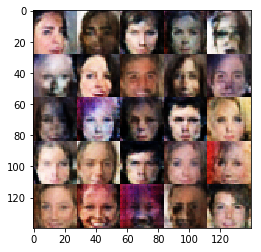

Epoch 1/1... Step 4010/6332... Discriminator Loss: 0.8583... Generator Loss: 1.3468
Epoch 1/1... Step 4020/6332... Discriminator Loss: 1.3184... Generator Loss: 0.5964
Epoch 1/1... Step 4030/6332... Discriminator Loss: 1.0820... Generator Loss: 0.8460
Epoch 1/1... Step 4040/6332... Discriminator Loss: 1.2952... Generator Loss: 0.6133
Epoch 1/1... Step 4050/6332... Discriminator Loss: 1.0598... Generator Loss: 1.4816
Epoch 1/1... Step 4060/6332... Discriminator Loss: 0.9914... Generator Loss: 1.2167
Epoch 1/1... Step 4070/6332... Discriminator Loss: 1.3340... Generator Loss: 0.5065
Epoch 1/1... Step 4080/6332... Discriminator Loss: 1.4774... Generator Loss: 0.4807
Epoch 1/1... Step 4090/6332... Discriminator Loss: 1.1588... Generator Loss: 0.7019
Epoch 1/1... Step 4100/6332... Discriminator Loss: 1.5817... Generator Loss: 0.4194
Epoch 1/1... Step 4110/6332... Discriminator Loss: 1.5459... Generator Loss: 0.4529
Epoch 1/1... Step 4120/6332... Discriminator Loss: 0.9748... Generator Loss:

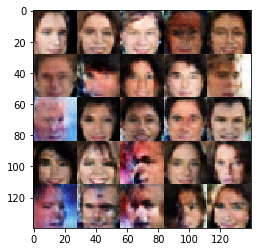

Epoch 1/1... Step 4210/6332... Discriminator Loss: 1.3366... Generator Loss: 0.5024
Epoch 1/1... Step 4220/6332... Discriminator Loss: 1.9029... Generator Loss: 0.2644
Epoch 1/1... Step 4230/6332... Discriminator Loss: 1.4051... Generator Loss: 0.4831
Epoch 1/1... Step 4240/6332... Discriminator Loss: 1.1886... Generator Loss: 1.3346
Epoch 1/1... Step 4250/6332... Discriminator Loss: 1.4284... Generator Loss: 0.4694
Epoch 1/1... Step 4260/6332... Discriminator Loss: 1.5452... Generator Loss: 0.3910
Epoch 1/1... Step 4270/6332... Discriminator Loss: 1.4211... Generator Loss: 0.4597
Epoch 1/1... Step 4280/6332... Discriminator Loss: 1.1153... Generator Loss: 0.9277
Epoch 1/1... Step 4290/6332... Discriminator Loss: 1.3027... Generator Loss: 0.5564
Epoch 1/1... Step 4300/6332... Discriminator Loss: 1.2784... Generator Loss: 0.7057
Epoch 1/1... Step 4310/6332... Discriminator Loss: 1.1518... Generator Loss: 0.6866
Epoch 1/1... Step 4320/6332... Discriminator Loss: 0.9698... Generator Loss:

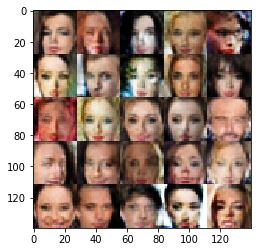

Epoch 1/1... Step 4410/6332... Discriminator Loss: 1.0084... Generator Loss: 0.9278
Epoch 1/1... Step 4420/6332... Discriminator Loss: 1.8114... Generator Loss: 0.2951
Epoch 1/1... Step 4430/6332... Discriminator Loss: 0.8699... Generator Loss: 1.2585
Epoch 1/1... Step 4440/6332... Discriminator Loss: 1.2321... Generator Loss: 0.7152
Epoch 1/1... Step 4450/6332... Discriminator Loss: 1.1150... Generator Loss: 0.7255
Epoch 1/1... Step 4460/6332... Discriminator Loss: 0.8894... Generator Loss: 1.0977
Epoch 1/1... Step 4470/6332... Discriminator Loss: 1.2568... Generator Loss: 0.6088
Epoch 1/1... Step 4480/6332... Discriminator Loss: 1.0453... Generator Loss: 1.2955
Epoch 1/1... Step 4490/6332... Discriminator Loss: 1.1192... Generator Loss: 1.0847
Epoch 1/1... Step 4500/6332... Discriminator Loss: 1.3850... Generator Loss: 0.4790
Epoch 1/1... Step 4510/6332... Discriminator Loss: 2.0459... Generator Loss: 0.2239
Epoch 1/1... Step 4520/6332... Discriminator Loss: 1.2444... Generator Loss:

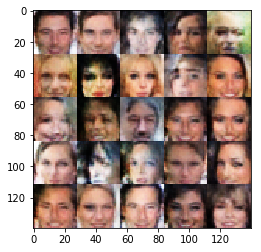

Epoch 1/1... Step 4610/6332... Discriminator Loss: 1.7027... Generator Loss: 0.3576
Epoch 1/1... Step 4620/6332... Discriminator Loss: 1.5761... Generator Loss: 0.4140
Epoch 1/1... Step 4630/6332... Discriminator Loss: 1.7104... Generator Loss: 0.3664
Epoch 1/1... Step 4640/6332... Discriminator Loss: 1.4173... Generator Loss: 0.4936
Epoch 1/1... Step 4650/6332... Discriminator Loss: 1.2913... Generator Loss: 0.5782
Epoch 1/1... Step 4660/6332... Discriminator Loss: 1.8874... Generator Loss: 0.2776
Epoch 1/1... Step 4670/6332... Discriminator Loss: 1.1067... Generator Loss: 0.8263
Epoch 1/1... Step 4680/6332... Discriminator Loss: 1.3793... Generator Loss: 0.4943
Epoch 1/1... Step 4690/6332... Discriminator Loss: 1.1371... Generator Loss: 0.9260
Epoch 1/1... Step 4700/6332... Discriminator Loss: 0.8403... Generator Loss: 1.5434
Epoch 1/1... Step 4710/6332... Discriminator Loss: 1.4715... Generator Loss: 0.4388
Epoch 1/1... Step 4720/6332... Discriminator Loss: 2.1009... Generator Loss:

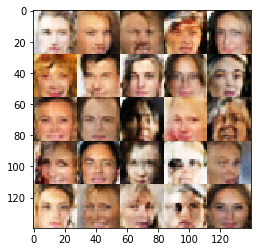

Epoch 1/1... Step 4810/6332... Discriminator Loss: 0.9435... Generator Loss: 0.9750
Epoch 1/1... Step 4820/6332... Discriminator Loss: 1.2634... Generator Loss: 0.6128
Epoch 1/1... Step 4830/6332... Discriminator Loss: 1.2294... Generator Loss: 1.6134
Epoch 1/1... Step 4840/6332... Discriminator Loss: 1.1330... Generator Loss: 1.7907
Epoch 1/1... Step 4850/6332... Discriminator Loss: 1.1267... Generator Loss: 0.7719
Epoch 1/1... Step 4860/6332... Discriminator Loss: 1.5128... Generator Loss: 0.4111
Epoch 1/1... Step 4870/6332... Discriminator Loss: 1.0468... Generator Loss: 1.5707
Epoch 1/1... Step 4880/6332... Discriminator Loss: 1.2896... Generator Loss: 1.5905
Epoch 1/1... Step 4890/6332... Discriminator Loss: 0.9534... Generator Loss: 1.2375
Epoch 1/1... Step 4900/6332... Discriminator Loss: 1.2992... Generator Loss: 0.5822
Epoch 1/1... Step 4910/6332... Discriminator Loss: 1.3853... Generator Loss: 0.4799
Epoch 1/1... Step 4920/6332... Discriminator Loss: 1.1147... Generator Loss:

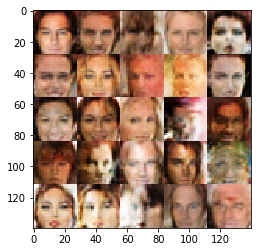

Epoch 1/1... Step 5010/6332... Discriminator Loss: 1.1561... Generator Loss: 0.6811
Epoch 1/1... Step 5020/6332... Discriminator Loss: 1.1890... Generator Loss: 2.1184
Epoch 1/1... Step 5030/6332... Discriminator Loss: 1.2686... Generator Loss: 0.5754
Epoch 1/1... Step 5040/6332... Discriminator Loss: 0.9146... Generator Loss: 1.2157
Epoch 1/1... Step 5050/6332... Discriminator Loss: 1.0439... Generator Loss: 1.2590
Epoch 1/1... Step 5060/6332... Discriminator Loss: 0.9990... Generator Loss: 1.1253
Epoch 1/1... Step 5070/6332... Discriminator Loss: 0.8684... Generator Loss: 1.5284
Epoch 1/1... Step 5080/6332... Discriminator Loss: 1.2891... Generator Loss: 0.5604
Epoch 1/1... Step 5090/6332... Discriminator Loss: 1.0141... Generator Loss: 1.3656
Epoch 1/1... Step 5100/6332... Discriminator Loss: 1.6922... Generator Loss: 0.3381
Epoch 1/1... Step 5110/6332... Discriminator Loss: 1.1259... Generator Loss: 0.7748
Epoch 1/1... Step 5120/6332... Discriminator Loss: 1.6993... Generator Loss:

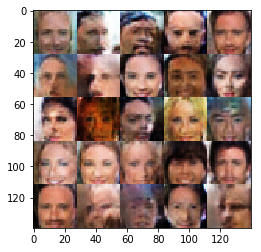

Epoch 1/1... Step 5210/6332... Discriminator Loss: 1.3088... Generator Loss: 0.5700
Epoch 1/1... Step 5220/6332... Discriminator Loss: 1.1420... Generator Loss: 0.8996
Epoch 1/1... Step 5230/6332... Discriminator Loss: 1.0530... Generator Loss: 0.9678
Epoch 1/1... Step 5240/6332... Discriminator Loss: 1.6663... Generator Loss: 0.3345
Epoch 1/1... Step 5250/6332... Discriminator Loss: 1.3006... Generator Loss: 0.5575
Epoch 1/1... Step 5260/6332... Discriminator Loss: 1.0810... Generator Loss: 1.3781
Epoch 1/1... Step 5270/6332... Discriminator Loss: 0.9691... Generator Loss: 1.0252
Epoch 1/1... Step 5280/6332... Discriminator Loss: 1.5763... Generator Loss: 0.4025
Epoch 1/1... Step 5290/6332... Discriminator Loss: 0.9018... Generator Loss: 1.2847
Epoch 1/1... Step 5300/6332... Discriminator Loss: 1.9499... Generator Loss: 0.2648
Epoch 1/1... Step 5310/6332... Discriminator Loss: 1.2335... Generator Loss: 0.6534
Epoch 1/1... Step 5320/6332... Discriminator Loss: 0.8804... Generator Loss:

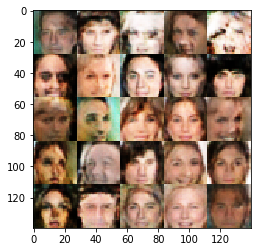

Epoch 1/1... Step 5410/6332... Discriminator Loss: 1.0346... Generator Loss: 1.0819
Epoch 1/1... Step 5420/6332... Discriminator Loss: 1.1310... Generator Loss: 1.1708
Epoch 1/1... Step 5430/6332... Discriminator Loss: 1.0502... Generator Loss: 1.0708
Epoch 1/1... Step 5440/6332... Discriminator Loss: 1.4584... Generator Loss: 0.4389
Epoch 1/1... Step 5450/6332... Discriminator Loss: 0.9529... Generator Loss: 1.2220
Epoch 1/1... Step 5460/6332... Discriminator Loss: 0.9543... Generator Loss: 1.0342
Epoch 1/1... Step 5470/6332... Discriminator Loss: 1.0966... Generator Loss: 0.7954
Epoch 1/1... Step 5480/6332... Discriminator Loss: 1.0493... Generator Loss: 0.8483
Epoch 1/1... Step 5490/6332... Discriminator Loss: 1.3059... Generator Loss: 0.5287
Epoch 1/1... Step 5500/6332... Discriminator Loss: 1.2788... Generator Loss: 0.5537
Epoch 1/1... Step 5510/6332... Discriminator Loss: 0.9015... Generator Loss: 1.5125
Epoch 1/1... Step 5520/6332... Discriminator Loss: 1.0927... Generator Loss:

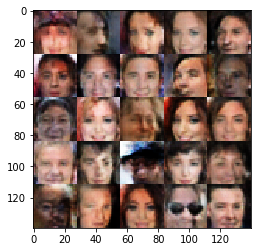

Epoch 1/1... Step 5610/6332... Discriminator Loss: 0.9704... Generator Loss: 1.6295
Epoch 1/1... Step 5620/6332... Discriminator Loss: 1.2454... Generator Loss: 1.0871
Epoch 1/1... Step 5630/6332... Discriminator Loss: 1.4328... Generator Loss: 0.4858
Epoch 1/1... Step 5640/6332... Discriminator Loss: 1.0803... Generator Loss: 0.7680
Epoch 1/1... Step 5650/6332... Discriminator Loss: 0.9236... Generator Loss: 1.1832
Epoch 1/1... Step 5660/6332... Discriminator Loss: 1.2147... Generator Loss: 2.1493
Epoch 1/1... Step 5670/6332... Discriminator Loss: 1.7107... Generator Loss: 0.3261
Epoch 1/1... Step 5680/6332... Discriminator Loss: 1.2213... Generator Loss: 0.6438
Epoch 1/1... Step 5690/6332... Discriminator Loss: 1.5784... Generator Loss: 0.3886
Epoch 1/1... Step 5700/6332... Discriminator Loss: 0.9539... Generator Loss: 1.0414
Epoch 1/1... Step 5710/6332... Discriminator Loss: 0.9657... Generator Loss: 1.0203
Epoch 1/1... Step 5720/6332... Discriminator Loss: 1.0897... Generator Loss:

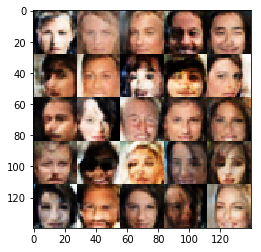

Epoch 1/1... Step 5810/6332... Discriminator Loss: 0.8842... Generator Loss: 1.3041
Epoch 1/1... Step 5820/6332... Discriminator Loss: 1.1074... Generator Loss: 0.8377
Epoch 1/1... Step 5830/6332... Discriminator Loss: 1.5359... Generator Loss: 0.4172
Epoch 1/1... Step 5840/6332... Discriminator Loss: 1.6936... Generator Loss: 0.3255
Epoch 1/1... Step 5850/6332... Discriminator Loss: 0.9566... Generator Loss: 1.0759
Epoch 1/1... Step 5860/6332... Discriminator Loss: 1.2232... Generator Loss: 1.8001
Epoch 1/1... Step 5870/6332... Discriminator Loss: 0.8912... Generator Loss: 1.1534
Epoch 1/1... Step 5880/6332... Discriminator Loss: 1.1795... Generator Loss: 0.7049
Epoch 1/1... Step 5890/6332... Discriminator Loss: 1.4402... Generator Loss: 0.4750
Epoch 1/1... Step 5900/6332... Discriminator Loss: 1.5880... Generator Loss: 0.3913
Epoch 1/1... Step 5910/6332... Discriminator Loss: 1.0997... Generator Loss: 0.6988
Epoch 1/1... Step 5920/6332... Discriminator Loss: 1.3362... Generator Loss:

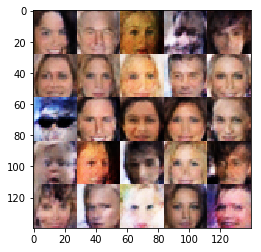

Epoch 1/1... Step 6010/6332... Discriminator Loss: 1.9426... Generator Loss: 0.2523
Epoch 1/1... Step 6020/6332... Discriminator Loss: 1.5275... Generator Loss: 0.4378
Epoch 1/1... Step 6030/6332... Discriminator Loss: 1.2771... Generator Loss: 0.5700
Epoch 1/1... Step 6040/6332... Discriminator Loss: 1.1761... Generator Loss: 1.0010
Epoch 1/1... Step 6050/6332... Discriminator Loss: 1.4965... Generator Loss: 0.4572
Epoch 1/1... Step 6060/6332... Discriminator Loss: 1.5604... Generator Loss: 0.4017
Epoch 1/1... Step 6070/6332... Discriminator Loss: 0.9553... Generator Loss: 1.5051
Epoch 1/1... Step 6080/6332... Discriminator Loss: 1.1042... Generator Loss: 0.8741
Epoch 1/1... Step 6090/6332... Discriminator Loss: 1.0798... Generator Loss: 0.7068
Epoch 1/1... Step 6100/6332... Discriminator Loss: 1.3555... Generator Loss: 0.5241
Epoch 1/1... Step 6110/6332... Discriminator Loss: 1.2826... Generator Loss: 0.5868
Epoch 1/1... Step 6120/6332... Discriminator Loss: 2.0311... Generator Loss:

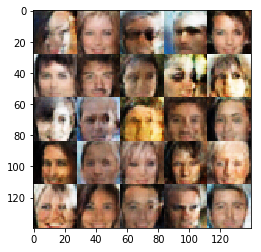

Epoch 1/1... Step 6210/6332... Discriminator Loss: 1.1038... Generator Loss: 0.7280
Epoch 1/1... Step 6220/6332... Discriminator Loss: 1.7235... Generator Loss: 0.3257
Epoch 1/1... Step 6230/6332... Discriminator Loss: 1.2039... Generator Loss: 0.7249
Epoch 1/1... Step 6240/6332... Discriminator Loss: 1.1944... Generator Loss: 0.6380
Epoch 1/1... Step 6250/6332... Discriminator Loss: 0.8101... Generator Loss: 1.2368
Epoch 1/1... Step 6260/6332... Discriminator Loss: 0.8562... Generator Loss: 2.2290
Epoch 1/1... Step 6270/6332... Discriminator Loss: 1.8031... Generator Loss: 0.2819
Epoch 1/1... Step 6280/6332... Discriminator Loss: 1.3040... Generator Loss: 0.5322
Epoch 1/1... Step 6290/6332... Discriminator Loss: 1.6655... Generator Loss: 0.3691
Epoch 1/1... Step 6300/6332... Discriminator Loss: 1.0335... Generator Loss: 0.9225
Epoch 1/1... Step 6310/6332... Discriminator Loss: 0.8218... Generator Loss: 1.2254
Epoch 1/1... Step 6320/6332... Discriminator Loss: 1.2939... Generator Loss:

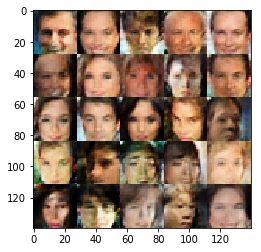

In [38]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3

losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

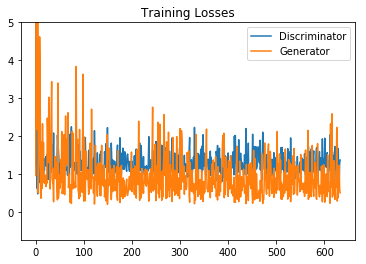

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.ylim(ymax=5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.